In [1]:
!pip install opencv-python-headless

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Load the video file
video_path = '/content/drive/MyDrive/10 sec 2D Test animation - Yanmotion (576p, h264, youtube).mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

Video opened successfully.


In [19]:
def compute_histogram_difference(frame1, frame2):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    hist1 = cv2.calcHist([gray1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([gray2], [0], None, [256], [0, 256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    diff = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return 1 - diff

In [20]:
# Step 1: Calculate the baseline for motion
motion_samples = []
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

for _ in range(50):
    ret1, frame1 = cap.read()
    ret2, frame2 = cap.read()
    if not (ret1 and ret2):
        break
    diff = compute_histogram_difference(frame1, frame2)
    motion_samples.append(diff)

mean_motion = np.mean(motion_samples)
std_motion = np.std(motion_samples)
motion_threshold = mean_motion + 2 * std_motion

print(f"Calculated motion threshold: {motion_threshold}")

Calculated motion threshold: 0.00020200366190035532


In [21]:
# Step 2: Process the video to detect events based on the calculated threshold
event_frames = []
frame_count = 0
fps = cap.get(cv2.CAP_PROP_FPS)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ret1, frame1 = cap.read()
    ret2, frame2 = cap.read()
    if not (ret1 and ret2):
        break

    frame_count += 1

    motion_intensity = compute_histogram_difference(frame1, frame2)

    if motion_intensity > motion_threshold:
        timestamp = str(timedelta(seconds=int(frame_count // fps)))

        diff_frame = cv2.absdiff(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY),
                                 cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY))
        _, thresh = cv2.threshold(diff_frame, 30, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(frame2, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.putText(frame2, f"Event at {timestamp}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        event_frames.append((frame2, timestamp))
        print(f"Event detected at frame {frame_count}, timestamp: {timestamp}")


cap.release()

Event detected at frame 45, timestamp: 0:00:01
Event detected at frame 46, timestamp: 0:00:01
Event detected at frame 54, timestamp: 0:00:02
Event detected at frame 55, timestamp: 0:00:02
Event detected at frame 56, timestamp: 0:00:02
Event detected at frame 57, timestamp: 0:00:02
Event detected at frame 59, timestamp: 0:00:02
Event detected at frame 105, timestamp: 0:00:04
Event detected at frame 106, timestamp: 0:00:04
Event detected at frame 107, timestamp: 0:00:04
Event detected at frame 108, timestamp: 0:00:04
Event detected at frame 126, timestamp: 0:00:05


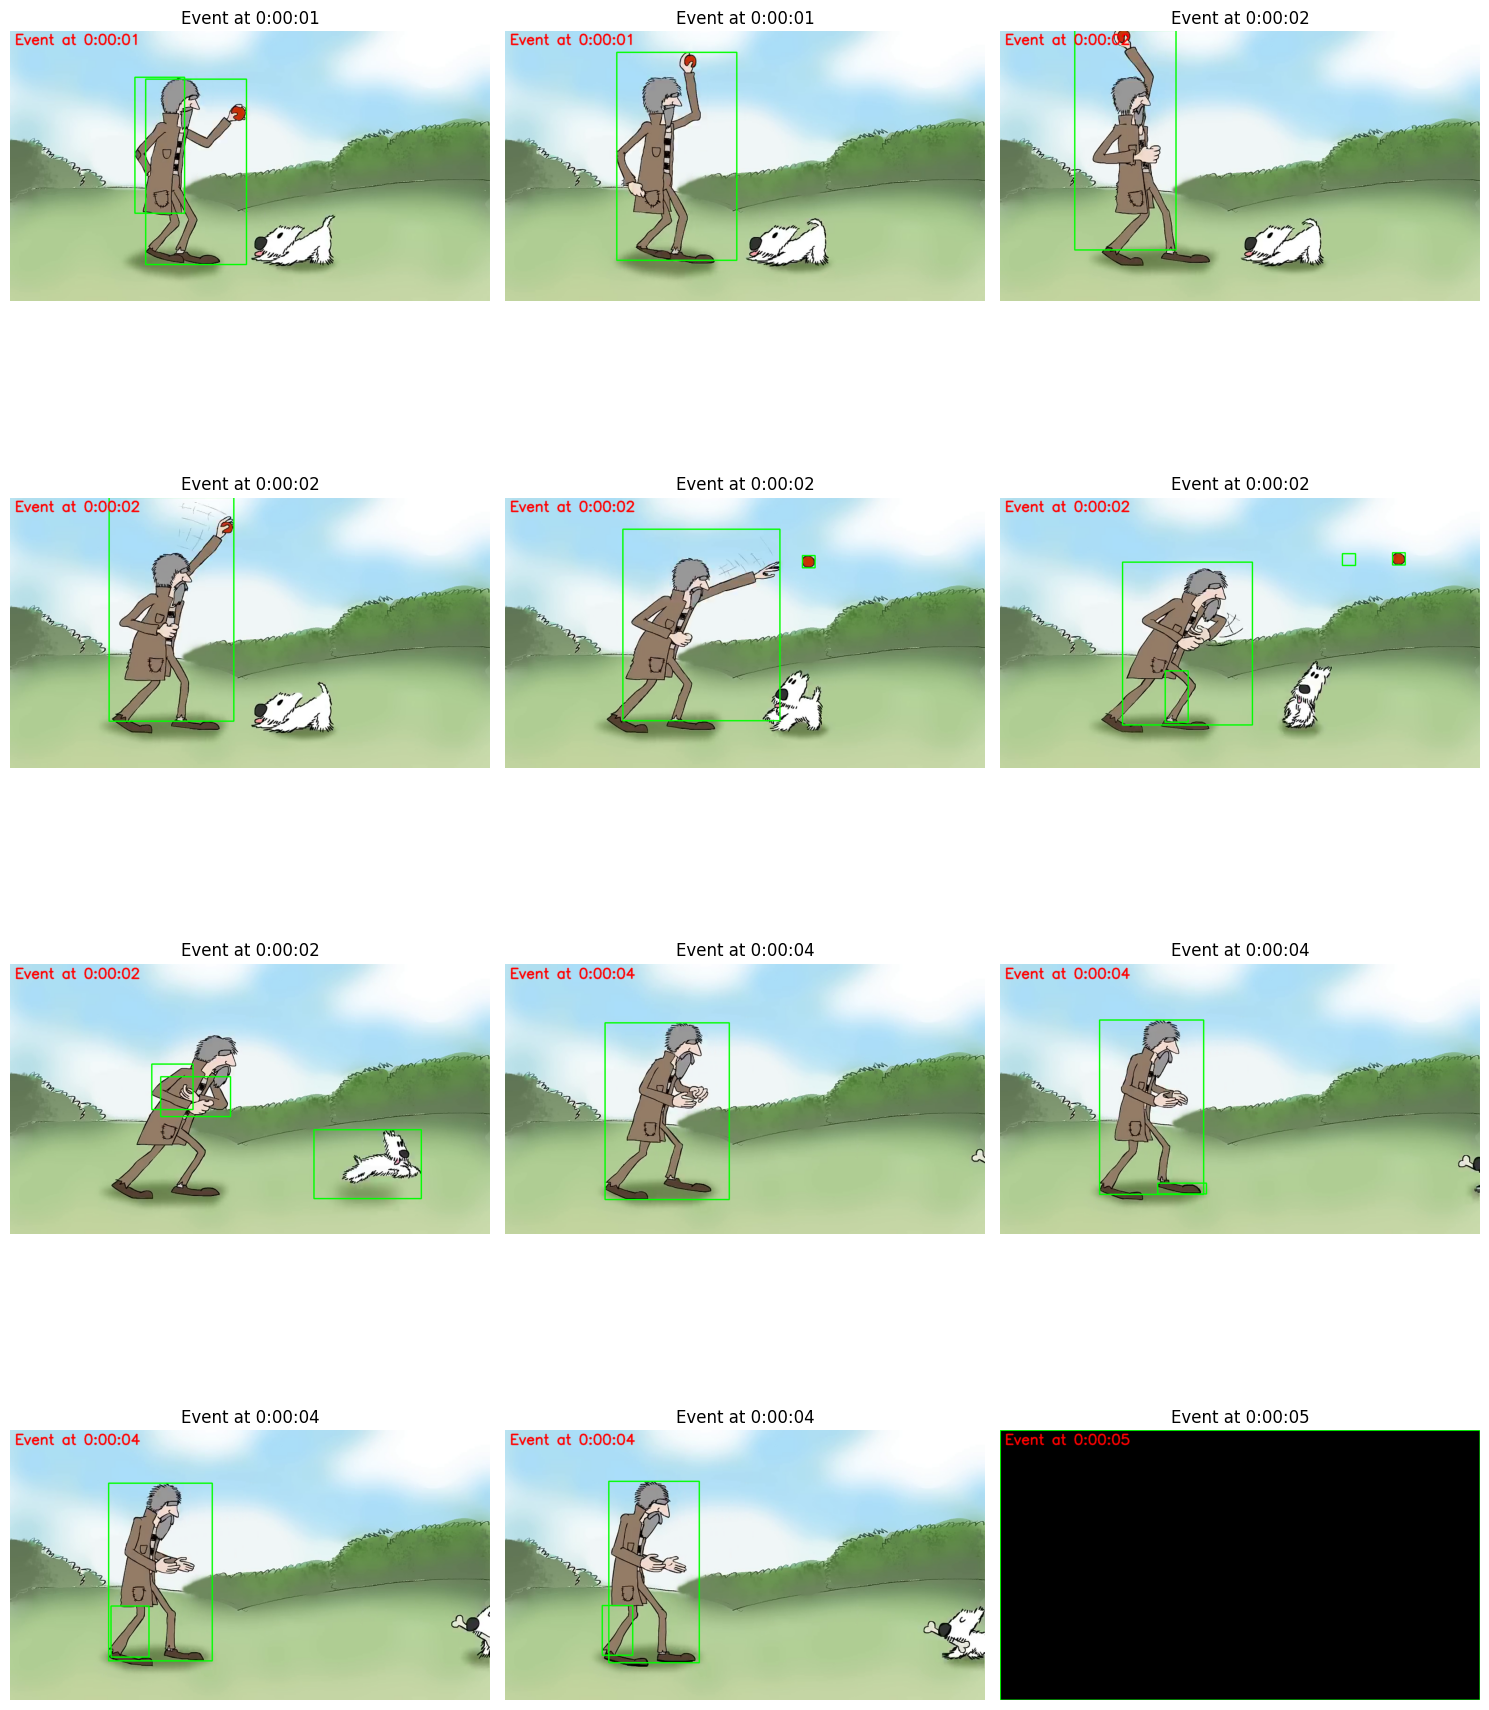

In [22]:
num_events = len(event_frames)
if num_events == 0:
    print("No significant events detected.")
else:
    cols = 3
    rows = math.ceil(num_events / cols)

    plt.figure(figsize=(15, rows * 5))

    for i, (frame, timestamp) in enumerate(event_frames):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame_rgb)
        plt.title(f"Event at {timestamp}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()